# Import Module and Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm

In [2]:
event_data = pd.read_csv('data/all_user_event_data.csv')
profile_data = pd.read_csv('data/all_user_profile_data.csv')
repo_data = pd.read_csv('data/all_user_repo_data.csv')
starred_data = pd.read_csv('data/all_user_starred_data.csv')

In [3]:
def SelectNumericColumn(df):
    return df.select_dtypes(include=[np.number])

In [4]:
def PlotCorr(df, title):
    corr = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, annot=True, cmap='coolwarm')
    plt.title(title)
    plt.show()
    return corr

In [5]:
def PlotPercentFreq(df, field, title, xlim):
    order = df[field].value_counts().index
    total = len(df)
    sns.barplot(y=df[field].value_counts().index, x=df[field].value_counts().values/total, order=order)
    plt.title(title)
    plt.xlim(0, xlim)
    plt.show()

In [6]:
def RegressionAnalyse(X, y):
    X1 = sm.add_constant(X)
    model = sm.OLS(y, X1)
    results = model.fit()
    return results

# Data Analysis

<b>Objective</b>: Get insights into the GitHub activity patterns of GitHub users with a high follower count.

The following steps will be undertaken to analyze the relationships:

<ul>
    <li>1. Determine if there are any disparities in the data fields between users with a high number of followers and those with fewer followers.</li>
    <li>2. If differences are found, conduct a detailed analysis to understand how these fields affect the number of followers and the nature of their influence.</li>
    <li>3. Visualize the data and perform statistical tests with a focus on significant values to better understand the patterns and trends.</li>
    <li>4. Repeat steps 1-3 for each data field.</li>
    <li>5. Compile and summarize the findings from each iteration.</li>
</ul>

## Selecting High-Follower User

In [7]:
threshold = 4 # Reasons for choosing threshold = 4 can be found in EDA notebook
high_follower_users = profile_data[profile_data['followers'] > threshold]

In [8]:
high_follower_users.head()

,user_alias,type,hireable,location,followers,following,public_repos,public_gists,created_at,updated_at
2,usr2,User,NaN,Karachi,13.0,23.0,44.0,NaN,2023-01-03T13:56:42Z,2023-12-24T05:10:36Z
10,usr10,User,True,Ho Chi Minh City/Viet Nam,126.0,170.0,50.0,17.0,2015-05-07T09:55:21Z,2023-12-14T15:56:05Z
11,usr11,User,NaN,Valencia/Spain,7.0,4.0,18.0,NaN,2019-03-04T16:50:46Z,2023-11-12T21:11:04Z
14,usr14,User,NaN,Athens/Greece,8.0,14.0,7.0,NaN,2020-11-11T20:12:32Z,2024-01-04T14:49:09Z
19,usr19,User,True,Rajshahi/Bangladesh.,15.0,27.0,18.0,NaN,2017-04-16T11:38:35Z,2022-04-07T17:56:46Z


In [9]:
len(high_follower_users)

2988

In [10]:
high_follower_aliases = high_follower_users['user_alias']

In [11]:
high_follower_aliases.head()

2      usr2
10    usr10
11    usr11
14    usr14
19    usr19
Name: user_alias, dtype: object

In [12]:
high_follower_event_data = event_data[event_data['user_alias'].isin(high_follower_aliases)]
high_follower_repo_data = repo_data[repo_data['user_alias'].isin(high_follower_aliases)]
high_follower_starred_data = starred_data[starred_data['user_alias'].isin(high_follower_aliases)]

In [13]:
low_follower_event_data = event_data[~event_data['user_alias'].isin(high_follower_aliases)]
low_follower_repo_data = repo_data[~repo_data['user_alias'].isin(high_follower_aliases)]
low_follower_starred_data = starred_data[~starred_data['user_alias'].isin(high_follower_aliases)]

## Analyze The Relationship

### Profile Data

#### Correlation Analysis

In [14]:
profile_data.head()

,user_alias,type,hireable,location,followers,following,public_repos,public_gists,created_at,updated_at
0,usr0,User,NaN,NaN,2.0,7.0,43.0,NaN,2020-09-07T23:54:51Z,2023-10-05T18:16:01Z
1,usr1,User,NaN,Tbilisi,3.0,4.0,16.0,NaN,2011-04-16T12:30:37Z,2024-01-08T13:45:16Z
2,usr2,User,NaN,Karachi,13.0,23.0,44.0,NaN,2023-01-03T13:56:42Z,2023-12-24T05:10:36Z
3,usr3,User,True,Karachi,NaN,NaN,5.0,NaN,2021-09-24T09:04:40Z,2023-05-02T19:11:00Z
4,usr4,User,NaN,NaN,1.0,NaN,2.0,NaN,2022-10-07T11:01:08Z,2023-12-07T20:03:36Z


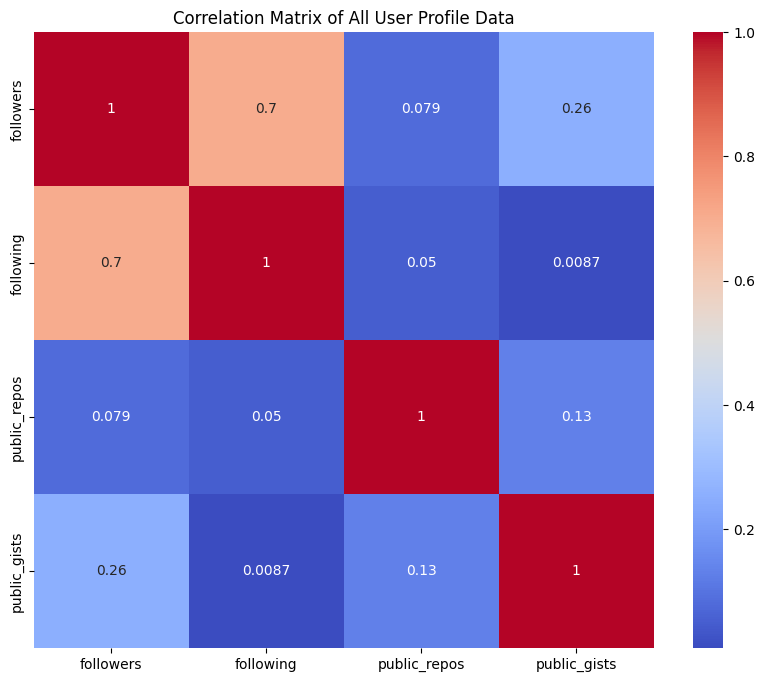

In [15]:
corr = PlotCorr(SelectNumericColumn(profile_data), title='Correlation Matrix of All User Profile Data')

In [16]:
corr

,followers,following,public_repos,public_gists
followers,1.000000,0.702345,0.079321,0.255694
following,0.702345,1.000000,0.050371,0.008656
public_repos,0.079321,0.050371,1.000000,0.129804
public_gists,0.255694,0.008656,0.129804,1.000000


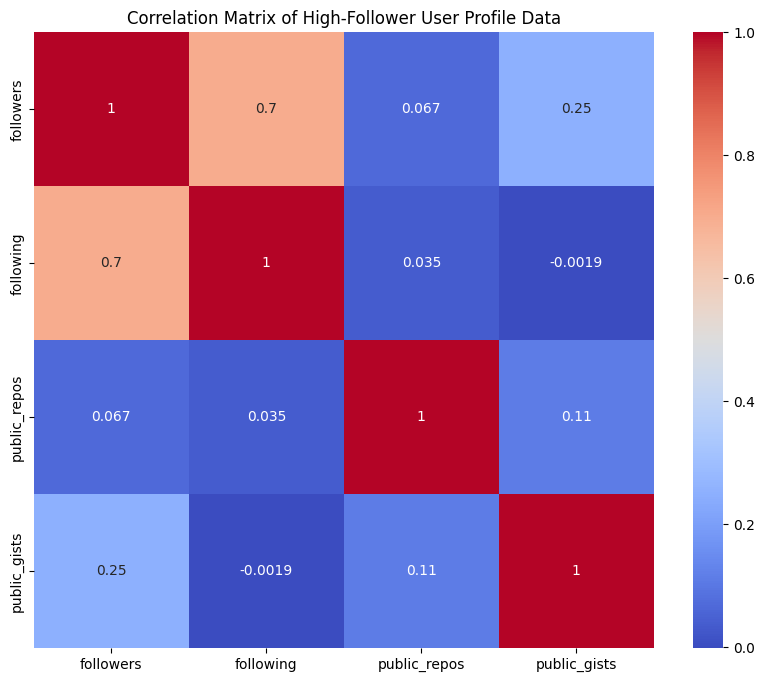

In [17]:
corr = PlotCorr(SelectNumericColumn(high_follower_users), title='Correlation Matrix of High-Follower User Profile Data')

In [18]:
corr

,followers,following,public_repos,public_gists
followers,1.000000,0.700527,0.067412,0.251672
following,0.700527,1.000000,0.034955,-0.001934
public_repos,0.067412,0.034955,1.000000,0.110392
public_gists,0.251672,-0.001934,0.110392,1.000000


By analyzing the Correlation Matrix of each field in the profile data of all users and specifically high-follower users and observing a significant correlation between the `following` and `followers` fields. A correlation coefficient of 0.702345 and 0.700527 indicates a strong positive relationship, suggesting that as the number of users one follows increases, so does the number of followers they have.

#### Regression Analysis of `following` and `followers`

In [19]:
profile_data = profile_data.dropna(subset=['following', 'followers'])

In [20]:
results = RegressionAnalyse(X = profile_data['following'], y = profile_data['followers'])
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              followers   R-squared:                       0.493
Model:                            OLS   Adj. R-squared:                  0.493
Method:                 Least Squares   F-statistic:                     5080.
Date:                Tue, 30 Jan 2024   Prob (F-statistic):               0.00
Time:                        16:54:02   Log-Likelihood:                -35017.
No. Observations:                5220   AIC:                         7.004e+04
Df Residuals:                    5218   BIC:                         7.005e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.7228      2.759      2.074      0.038       0.314      11.132
following      0.8106      0.011     71.272      0.000       0.788       0.833
==============================================================================
Omnibus:                    12617.647   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        203386733.847
Skew:                          24.720   Prob(JB):                         0.00
Kurtosis:                     968.747   Cond. No.                         244.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

R-squared = 0.493, This is a statistical measure that represents the proportion of the variance for the dependent variable that's explained by the independent variable. Meaning that approximately 49.3% of the variability in `followers` can be explained by `following`.

F-statistic = 5080, This is a measure of how significant the fit of the model is.

Prob (F-statistic) = 0.00 (The associated p-value) is less than 0.05 means that the independent variable, `following`, is a statistically significant predictor of `followers`.

coef for `following` = 0.8106, This is the change in the `followers` variable for a one-unit change in the `following` variable, holding all other variables constant. In this case, for each additional user that someone follows, their followers will increase by about 0.81.

### Event Data

#### Plot Percentage Of Event Frequency

In [21]:
event_data.head()

,user_alias,event_type,created_at
0,usr1,PushEvent,2023-10-31T17:57:39Z
1,usr1,CreateEvent,2023-10-30T18:13:26Z
2,usr1,CreateEvent,2023-10-30T17:53:32Z
3,usr2,CreateEvent,2024-01-08T17:29:08Z
4,usr2,CreateEvent,2024-01-08T17:27:38Z


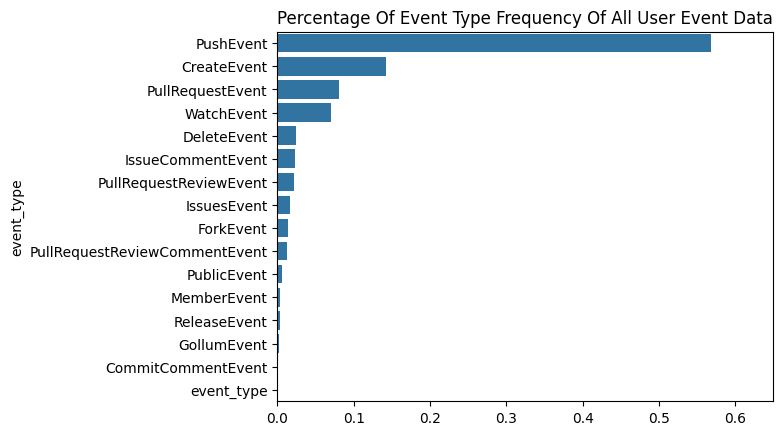

In [22]:
PlotPercentFreq(event_data, 'event_type', title='Percentage Of Event Type Frequency Of All User Event Data', xlim=0.65)

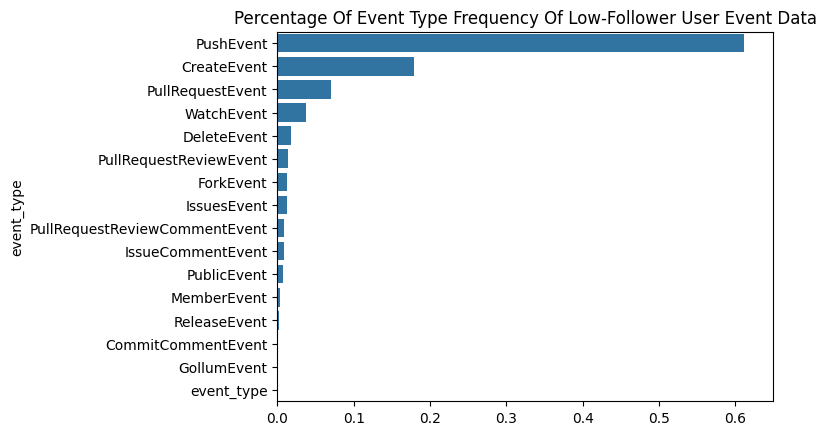

In [23]:
PlotPercentFreq(low_follower_event_data, 'event_type', title='Percentage Of Event Type Frequency Of Low-Follower User Event Data', xlim=0.65)

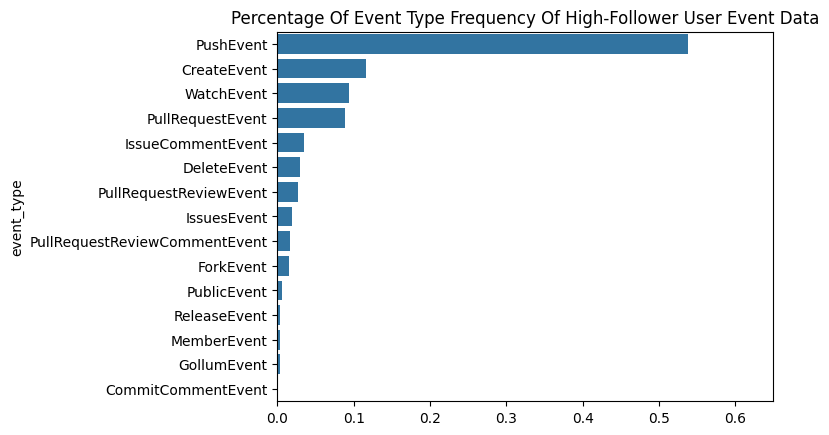

In [24]:
PlotPercentFreq(high_follower_event_data, 'event_type', title='Percentage Of Event Type Frequency Of High-Follower User Event Data', xlim=0.65)

These BarChart revealed a notable difference in the frequency of three specific event types: `PushEvent`, `CreateEvent` and `WatchEvent`.

`PushEvent` This could imply that high-follower users tend to push data to their GitHub repositories more frequently than low-follower users.

`CreateEvent` High-follower users have a lower frequency of CreateEvent compared to both low-follower users and the overall user base. This could imply that high-follower may not create new repositories as often as their low-follower counterparts.

`WatchEvent` High-follower users also have a higher frequency of WatchEvent. This indicates that they are more likely to watch or follow other users' repositories. This could be a reflection of their engagement with the GitHub community, keeping track of others' works and possibly gaining inspiration for their own projects.

#### Regression Analysis of `PushEvent`, `CreateEvent` and `WatchEvent` Frequency

In [25]:
event_counts = high_follower_event_data.groupby(['user_alias', 'event_type']).size().unstack(fill_value=0)
event_counts.reset_index(inplace=True)

merged_data = pd.merge(profile_data[['user_alias', 'followers']], event_counts, on='user_alias')

In [26]:
merged_data.head()

,user_alias,followers,CommitCommentEvent,CreateEvent,DeleteEvent,ForkEvent,GollumEvent,IssueCommentEvent,IssuesEvent,MemberEvent,PublicEvent,PullRequestEvent,PullRequestReviewCommentEvent,PullRequestReviewEvent,PushEvent,ReleaseEvent,WatchEvent
0,usr2,13.0,1,27,0,0,0,0,0,1,0,0,0,0,8,0,0
1,usr10,126.0,0,0,0,1,0,1,0,0,0,0,0,0,4,0,189
2,usr11,7.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,usr14,8.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,usr21,5.0,0,12,0,0,0,0,0,0,0,0,0,0,18,0,0


In [27]:
y = merged_data['followers']

##### `PushEvent`

In [28]:
results = RegressionAnalyse(X = merged_data['PushEvent'], y = merged_data['followers'])
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              followers   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     12.93
Date:                Tue, 30 Jan 2024   Prob (F-statistic):           0.000332
Time:                        16:54:03   Log-Likelihood:                -13128.
No. Observations:                1875   AIC:                         2.626e+04
Df Residuals:                    1873   BIC:                         2.627e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         32.9230      7.232      4.553      0.000      18.740      47.106
PushEvent      0.4553      0.127      3.596      0.000       0.207       0.704
==============================================================================
Omnibus:                     4463.058   Durbin-Watson:                   2.014
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         31667311.918
Skew:                          23.385   Prob(JB):                         0.00
Kurtosis:                     637.944   Cond. No.                         67.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The p-value for `PushEvent` is 0.000332, which is less than 0.05. Therefore, the initial assumption that high-follower users tend to push data to their GitHub repositories more frequently than low-follower users is statistically supported.

##### `CreateEvent`

In [29]:
results = RegressionAnalyse(X = merged_data['CreateEvent'], y = merged_data['followers'])
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              followers   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     16.64
Date:                Tue, 30 Jan 2024   Prob (F-statistic):           4.70e-05
Time:                        16:54:04   Log-Likelihood:                -13126.
No. Observations:                1875   AIC:                         2.626e+04
Df Residuals:                    1873   BIC:                         2.627e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          30.9201      7.246      4.267      0.000      16.708      45.132
CreateEvent     2.4192      0.593      4.080      0.000       1.256       3.582
==============================================================================
Omnibus:                     4484.253   Durbin-Watson:                   2.015
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         32963154.570
Skew:                          23.648   Prob(JB):                         0.00
Kurtosis:                     650.836   Cond. No.                         14.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The p-value for `CreateEvent` is 4.70e-05, which is also less than 0.05. Therefore, the assumption that high-follower users create new repositories less often than low-follower users is statistically supported.

##### `WatchEvent`

In [30]:
results = RegressionAnalyse(X = merged_data['WatchEvent'], y = merged_data['followers'])
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              followers   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.823
Date:                Tue, 30 Jan 2024   Prob (F-statistic):              0.177
Time:                        16:54:04   Log-Likelihood:                -13133.
No. Observations:                1875   AIC:                         2.627e+04
Df Residuals:                    1873   BIC:                         2.628e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         43.9758      6.471      6.796      0.000      31.284      56.667
WatchEvent     0.5067      0.375      1.350      0.177      -0.229       1.243
==============================================================================
Omnibus:                     4487.219   Durbin-Watson:                   2.013
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         32937772.394
Skew:                          23.690   Prob(JB):                         0.00
Kurtosis:                     650.579   Cond. No.                         18.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

the p-value for `WatchEvent` is 0.177, which is greater than 0.05. This means that the frequency of `WatchEvent` does not have a statistically significant impact on the number of followers. Therefore, the initial assumption about the impact of WatchEvent frequency on the number of followers does not hold true.

### Repo Data

In [31]:
repo_data.head()

,user_alias,description,fork,stargazers_count,language,topics,forks
0,usr0,NaN,NaN,NaN,JavaScript,NaN,NaN
1,usr0,NaN,NaN,NaN,JavaScript,NaN,NaN
2,usr0,NaN,NaN,NaN,JavaScript,NaN,NaN
3,usr0,NaN,NaN,NaN,JavaScript,NaN,NaN
4,usr0,NaN,NaN,NaN,JavaScript,NaN,NaN


### Analyzing the correlation between providing repository descriptions and topics, and the follower count for all users.

In [32]:
all_users_percentages = repo_data.groupby('user_alias')[['description', 'topics']].apply(lambda x: x.notna().mean() * 100)

In [33]:
merged_data = pd.merge(profile_data[['user_alias', 'followers']], all_users_percentages, on='user_alias')

In [34]:
merged_data.head()

,user_alias,followers,description,topics
0,usr0,2.0,46.511628,0.00
1,usr1,3.0,56.250000,0.00
2,usr2,13.0,13.043478,0.00
3,usr6,1.0,52.631579,0.00
4,usr7,3.0,81.250000,6.25


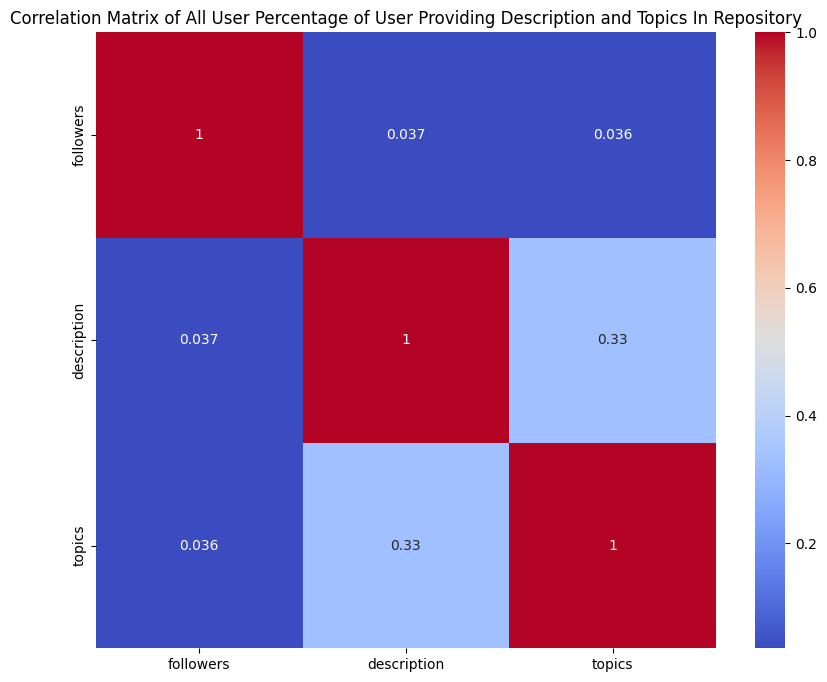

In [35]:
corr = PlotCorr(SelectNumericColumn(merged_data), title='Correlation Matrix of All User Percentage of User Providing Description and Topics In Repository')

By analyzing the correlation matrix, which encompasses the percentage of all users providing descriptions and topics, no significant correlation was found.

### Analyzing the correlation between numbers of star and forks, with the follower count for all users.

In [36]:
user_aggregates = repo_data.groupby('user_alias')[['stargazers_count', 'forks']].sum().reset_index()

In [37]:
merged_data = pd.merge(profile_data[['user_alias', 'followers']], user_aggregates, on='user_alias')

In [38]:
merged_data.head()

,user_alias,followers,stargazers_count,forks
0,usr0,2.0,0.0,0.0
1,usr1,3.0,0.0,0.0
2,usr2,13.0,13.0,0.0
3,usr6,1.0,1.0,1.0
4,usr7,3.0,4.0,0.0


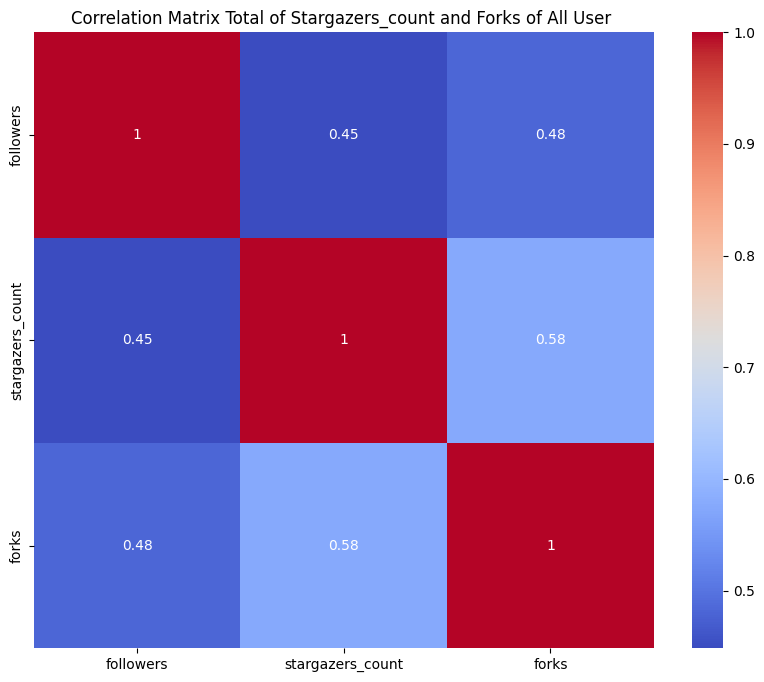

In [39]:
corr = PlotCorr(SelectNumericColumn(merged_data), title='Correlation Matrix Total of Stargazers_count and Forks of All User ')

By analyzing the correlation matrix, which encompasses the total of all users stargazers count and forks, no significant correlation was found.